In [15]:
# user input
dimension = 7
conditioning_indicator = 0.5 # 0 = well-conditioned, 1 = badly conditioned
noise_indicator = 0 # 0 = no noise,1 = some noise
use_cvxpy = True #set to False if not installed

In [16]:
# set up python
import numpy as np
from scipy import optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from cvxpy import *
# plot properties
# use to create figures for tex
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [17]:
#define quadratic function, gradient, and Hessian for scipy.optimize

#define initial guess and coefficients a_i
x0 = np.ndarray(dimension)
x0[:2] = ([4.5,-1.5])
x0[2:] = np.zeros(dimension-2)

minimum = np.ones(dimension)
conditioning_factor = conditioning_indicator * 20
noise_coeff = 0.5*noise_indicator
quadratic_coeff = np.array(np.exp(np.random.random(dimension)*conditioning_factor))
quadratic_coeff = quadratic_coeff/np.max(quadratic_coeff)
print('condition number of Hessian of quadratic part is ',np.max(quadratic_coeff)/np.min(quadratic_coeff))

x=quadratic_coeff
cvxrun=False
def fun(x):
    return 0.5*sum(np.multiply(quadratic_coeff,np.square(np.array(x)-np.ones(np.array(x).size)))) \
        +dimension*noise_coeff- noise_coeff*sum(np.cos(2*np.pi*(np.array(x)-np.ones(np.array(x).size))))
        
def fun_grad(x):
    return np.array(np.multiply(quadratic_coeff,np.array(x)-np.ones(np.array(x).size))) \
        + noise_coeff*2*np.pi*np.array(np.sin(2*np.pi*(np.array(x)-np.ones(np.array(x).size))))
    
def fun_hess(x):
    return np.diag(quadratic_coeff)\
        + noise_coeff*4*np.square(np.pi)*np.diag(np.cos(2*np.pi*(np.array(x)-np.ones(np.array(x).size))))
    
# verify that analytical gradient is correct. returns 0 if correct
print('If (close to) zero, gradient implemented correctly: ',opt.check_grad(fun,fun_grad,x0*np.random.random(1)))
fig_suffix='dim'+str(dimension)+'_cond'+str(conditioning_factor)+'noise'+str(noise_indicator)+'.pdf'

condition number of Hessian of quadratic part is  1871.89445309
If (close to) zero, gradient implemented correctly:  1.69329308953e-08


In [18]:
# plotting scriptS for objective function

# surface plot
def plot_surf(X,Y,Z):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)

    plt.xlabel('variable $x_1$')
    plt.ylabel('variable $x_2$')
    # Add a color bar which maps values to colors.
    fig.colorbar(surf)
    #plt.title('function to minimize, dimension = %d, a = %1.2f' % (dimension, conditioning_factor)
    plt.title('objective function')


    #plt.savefig('fig/1d-fit-ls3d.pdf')
    return plt
    
# contour plot with optimization iterates
def plot_contour(allvecs,legend_path):
    fig = plt.figure()
    #contour_levels=np.logspace(-0.5,3.5,5,base=10)
    #CS = plt.contour(X,Y,Z,levels=contour_levels)
    CS = plt.contour(X,Y,Z)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.title('objective function')
    plt.xlabel('variable $x_1$')
    plt.ylabel('variable $x_2$')
    plt.rc('text', usetex=False)
    plt.rc('font', family='serif')
    plt.plot(minimum[0],minimum[1],'r*',markersize=10,label='minimum')
    plt.plot(x0[0],x0[1],'bx',markersize=10,label='initial guess')
    plt.plot(np.array(allvecs)[:,0],np.array(allvecs)[:,1],'go',markersize=4,label=legend_path)
    plt.legend()
    return plt

In [19]:
# create data to visualize objetive function
n = 100 # number of discretization points along the x-axis
m = 100 # number of discretization points along the x-axis
a=-2.; b=5. # extreme points in the x-axis
c=-2; d=5. # extreme points in the y-axis

X,Y = np.meshgrid(np.linspace(a,b,n), np.linspace(c,d,m))
Z=np.zeros(X.shape)

argument=np.zeros(x0.size)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        argument[0] = X[i,j]
        argument[1] = Y[i,j]
        argument[2:] = np.ones(x0.size-2)
        Z[i][j] = fun(argument)

/Users/anirudhnatarajan/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


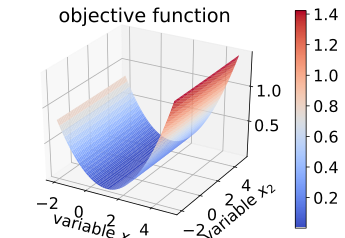

In [20]:
plt=plot_surf(X,Y,Z)

/Users/anirudhnatarajan/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


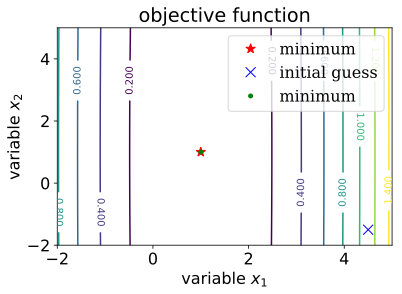

In [21]:
plt=plot_contour(np.array([[1,1]]),'minimum')

#initialize data to store number of function evals
nfev = list()
name=list()
distance=list()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 64
         Function evaluations: 129
         Gradient evaluations: 129


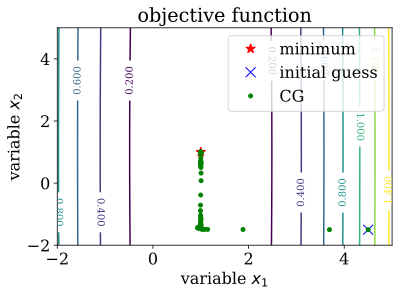

In [22]:
method_name = 'CG'
method_name_legend = method_name
res = opt.minimize(fun,x0,method='CG',jac=fun_grad,options={'disp' : True,'return_all':True})
plot_contour(res.allvecs,method_name_legend)
nfev = nfev + [res.nfev]
name = name + [method_name_legend]
distance = distance + [np.linalg.norm(res.x-minimum)/np.linalg.norm(minimum)]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 94
         Function evaluations: 1710
         Gradient evaluations: 190


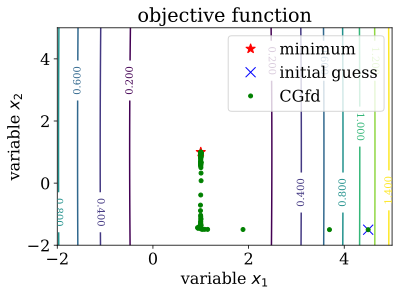

In [23]:
method_name = 'CG'
method_name_legend = method_name + 'fd'
res = opt.minimize(fun,x0,method='CG',options={'disp' : True,'return_all':True})
plot_contour(res.allvecs,method_name_legend)
nfev = nfev + [res.nfev]
name = name + [method_name_legend]
distance = distance + [np.linalg.norm(res.x-minimum)/np.linalg.norm(minimum)]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 14
         Hessian evaluations: 7


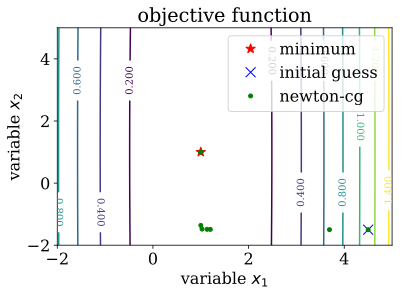

In [24]:
method_name = 'newton-cg'
method_name_legend = method_name
res = opt.minimize(fun,x0,method=method_name,jac=fun_grad,hess=fun_hess,options={'disp' : True,'return_all':True})
plot_contour(res.allvecs,method_name_legend)
nfev = nfev + [res.nfev]
name = name + [method_name_legend]
distance = distance + [np.linalg.norm(res.x-minimum)/np.linalg.norm(minimum)]

Optimization terminated successfully.
         Current function value: 0.153618
         Iterations: 1577
         Function evaluations: 2379


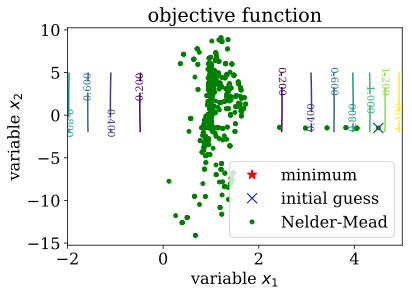

In [25]:
# minimize
method_name = 'Nelder-Mead'
method_name_legend = method_name
res = opt.minimize(fun,x0,method=method_name,options={'disp' : True,'return_all':True,'maxfev':100000})
plot_contour(res.allvecs,method_name_legend)
nfev = nfev + [res.nfev]
name = name + [method_name_legend]
distance = distance + [np.linalg.norm(res.x-minimum)/np.linalg.norm(minimum)]

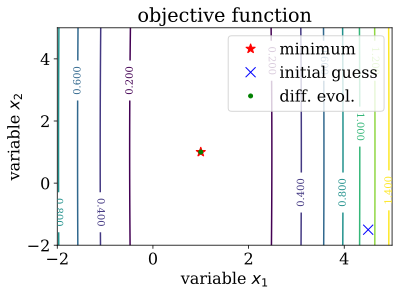

In [26]:
# minimize
method_name = 'diff. evol.'
method_name_legend = method_name
bounds = np.ndarray([minimum.size,2])
bounds[:,0] = -10*np.ones(minimum.size)
bounds[:,1] = 10*np.ones(minimum.size)
res = opt.differential_evolution(fun,bounds)
sol = np.array([[res.x[0]],[res.x[1]]])
plot_contour(sol.T,method_name_legend)
nfev = nfev + [res.nfev]
name = name + [method_name_legend]
distance = distance + [np.linalg.norm(res.x-minimum)/np.linalg.norm(minimum)]

hi


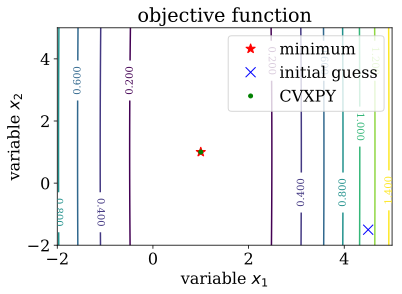

In [27]:
if noise_indicator == 0 and use_cvxpy == True:
    import cvxpy as cvx
    print("hi")
    method_name_legend = 'CVXPY'
    x = cvx.Variable(dimension)
    quadratic_coeff_cvx = cvx.Parameter(dimension,sign='Positive')
    quadratic_coeff_cvx.value=quadratic_coeff
    obj = cvx.Minimize(0.5*quadratic_coeff.T*cvx.square(x-1))
    prob = cvx.Problem(obj)
    prob.solve()
    plot_contour(x.value[:2].T,method_name_legend)
    distance = distance + [np.linalg.norm(res.x-minimum)/np.linalg.norm(minimum)]
    cvxrun = True

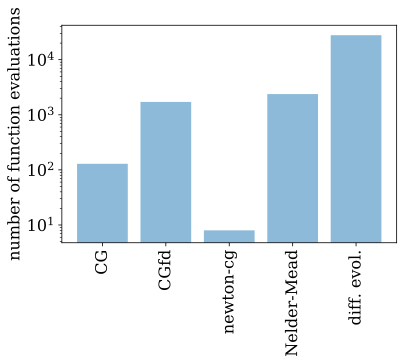

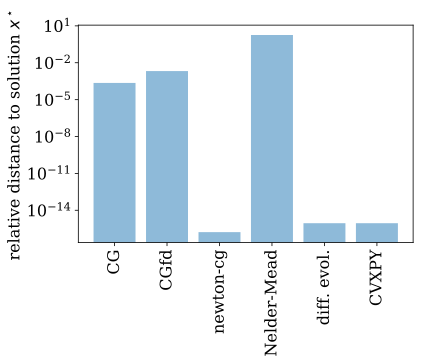

In [28]:
#bar plots of results
y_pos = np.arange(len(name))
plt.bar(y_pos, nfev, align='center', alpha=0.5,log=1)
plt.xticks(y_pos, name,rotation='vertical')
plt.ylabel('number of function evaluations')
plt.show()

y_pos = np.arange(len(distance))
plt.bar(y_pos, distance, align='center', alpha=0.5,log=1)
if cvxrun:
    plt.xticks(y_pos, name+['CVXPY'],rotation='vertical')
else:
    plt.xticks(y_pos,name, rotation='vertical')
plt.ylabel('relative distance to solution $x^\star$')
plt.show()